# CS-484: Intro to ML - Assignment 5

### Author: Jorge Gonzalez Lopez
### CWID: A20474413
### Semester: Spring 2021

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from sklearn import naive_bayes, svm, metrics
from sklearn.linear_model import LogisticRegression
import sklearn.tree as tree
import sklearn.ensemble as ensemble
import statsmodels.api as stats
import scipy
import random


## Question 1

In [3]:
df = pd.read_csv('WineQuality_Train.csv')

In [4]:
input_features = ['alcohol', 'citric_acid', 'free_sulfur_dioxide', 'residual_sugar', 'sulphates']
X = df[input_features]

target = 'quality_grp'
y = df[target].astype('category')

In [5]:
X

,alcohol,citric_acid,free_sulfur_dioxide,residual_sugar,sulphates
0,9.0,0.43,27.0,7.80,0.55
1,10.3,0.19,37.0,14.50,0.43
2,12.6,0.28,64.0,1.90,0.60
3,10.8,0.36,31.0,2.05,0.44
4,12.0,0.52,32.0,1.40,0.45
...,...,...,...,...,...
4542,11.0,0.28,27.0,8.30,0.37
4543,9.9,0.05,13.0,2.20,0.55
4544,11.4,0.30,38.0,1.40,0.57
4545,9.7,0.34,33.0,8.30,0.64


In [6]:
y

0       1
1       0
2       1
3       0
4       0
       ..
4542    0
4543    0
4544    1
4545    0
4546    0
Name: quality_grp, Length: 4547, dtype: category
Categories (2, int64): [0, 1]

In [7]:
crit = 'entropy'
max_d = 5
rnd_st = 20210415
max_ite = 50

In [16]:
df_test = pd.read_csv('WineQuality_Test.csv')
X_test = df_test[input_features]
y_test = df_test[target].astype('category')

In [85]:
w_train = np.full(X.shape[0], 1.0)
accuracy = []
accuracy_test = []
ensemblePredProb = np.zeros((X.shape[0], 2))

ensemblePredProb_test = np.zeros((X_test.shape[0], 2))


for iter in range(max_ite):
    classTree = tree.DecisionTreeClassifier(criterion=crit, max_depth=max_d, random_state=rnd_st)
    treeFit = classTree.fit(X, y, w_train)
    
    treePredProb = classTree.predict_proba(X)
    y_pred = np.where(treePredProb[:,1] >= 0.2, 1, 0)
    accuracy.append(np.sum(np.where(y_pred == y, w_train, 0)) / np.sum(w_train))
    ensemblePredProb += accuracy[iter] * treePredProb
    
    treePredProb_test = classTree.predict_proba(X_test)
    y_pred_test = np.where(treePredProb_test[:,1] >= 0.2, 1, 0)
    accuracy_test.append(np.mean(np.where(y_pred_test == y_test, 1, 0)))
    ensemblePredProb_test += accuracy_test[iter] * treePredProb_test
    
    
    if (abs(1.0 - accuracy[iter]) < 0.0000001):
        print('\n Iteration ', iter ,': Max accuracy achieved')
        break
    
    # Update the weights
    eventError = np.where(y == 1, (1 - treePredProb[:,1]), treePredProb[:,1])
    predClass = np.where(treePredProb[:,1] >= 0.2, 1, 0)
    w_train = np.where(predClass != y, 2+np.abs(eventError), np.abs(eventError))
    
    if iter in [0,1,2,3,4]:
        print('\n Misclassification rate for iteration ', iter, ' :')
        print('\n ', accuracy[iter])
    

# Calculate the final predicted probabilities
ensemblePredProb /= np.sum(accuracy)
ensemblePredProb_test /= np.sum(accuracy_test)

#final_pred = np.where(ensemblePredProb[:,1] >= 0.2, 1, 0)
print('\n Final Misclassification rate:')
print('\n ', 1 - accuracy[-1])


 Misclassification rate for iteration  0  :

  0.2471959533758522

 Misclassification rate for iteration  1  :

  0.1601657094959913

 Iteration  17 : Max accuracy achieved

 Final Misclassification rate:

  8.744448964925766e-08


In [86]:
final_pred_test = np.where(ensemblePredProb_test[:,1] >= 0.2, 1, 0)
AUC = metrics.roc_auc_score(y_test, final_pred_test)

print('\n AUC = ', AUC)



 AUC =  0.5217044935894776


In [87]:
df_test['Predictions_1'] = ensemblePredProb_test[:,1]

print(df_test['Predictions_1'])

0       0.631078
1       0.680032
2       0.303750
3       0.643943
4       0.303549
          ...   
1945    0.634436
1946    0.309736
1947    0.297918
1948    0.275715
1949    0.314628
Name: Predictions_1, Length: 1950, dtype: float64


KeyError: 'Column not found: P_BAD1'

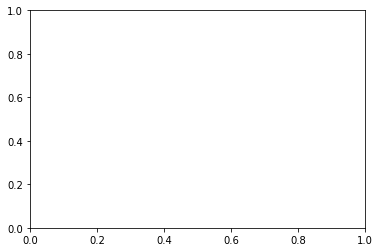

In [110]:
df_test.boxplot(column='P_BAD1', by=target, vert = False, figsize=(6,4))
plt.title("Boxplot of P_BAD1 by Levels of BAD")
plt.suptitle(" ")
plt.xlabel("P_BAD1")
plt.ylabel("BAD")
plt.grid(axis="y")
plt.show()

## Question 2

In [91]:
input_features = ['alcohol', 'citric_acid', 'free_sulfur_dioxide', 'residual_sugar', 'sulphates']
X = df[input_features]

target = 'quality_grp'
y = df[target].astype('category')

In [92]:
def SWEEPOperator (pDim, inputM, tol):
    # pDim: dimension of matrix inputM, integer greater than one
    # inputM: a square and symmetric matrix, numpy array
    # tol: singularity tolerance, positive real

    aliasParam = []
    nonAliasParam = []
    
    A = np.copy(inputM)
    diagA = np.diagonal(inputM)

    for k in range(pDim):
        Akk = A[k,k]
        if (Akk >= (tol * diagA[k])):
            nonAliasParam.append(k)
            ANext = A - np.outer(A[:, k], A[k, :]) / Akk
            ANext[:, k] = A[:, k] / Akk
            ANext[k, :] = ANext[:, k]
            ANext[k, k] = -1.0 / Akk
        else:
            aliasParam.append(k)
            ANext[:, k] = 0.0 * A[:, k]
            ANext[k, :] = ANext[:, k]
        A = ANext
    return (A, aliasParam, nonAliasParam)


def build_mnlogit (fullX, y):

    # Find the non-redundant columns in the design matrix fullX
    nFullParam = fullX.shape[1]
    XtX = np.transpose(fullX).dot(fullX)
    invXtX, aliasParam, nonAliasParam = SWEEPOperator(pDim = nFullParam, inputM = XtX, tol = 1e-7)

    # Build a multinomial logistic model
    X = fullX.iloc[:, list(nonAliasParam)]
    logit = stats.MNLogit(y, X)
    thisFit = logit.fit(method = 'newton', maxiter = 1000, gtol = 1e-6, full_output = True, disp = True)
    thisParameter = thisFit.params
    thisLLK = logit.loglike(thisParameter.values)

    # The number of free parameters
    nYCat = thisFit.J
    thisDF = len(nonAliasParam) * (nYCat - 1)

    # Return model statistics
    return (thisLLK, thisDF, thisParameter, thisFit)

In [93]:
devianceTable = pd.DataFrame()

u = pd.DataFrame()

# Step 0: Intercept only model
u = y.isnull()
designX = pd.DataFrame(u.where(u, 1)).rename(columns = {target: "const"})
LLK0, DF0, fullParams0, thisFit = build_mnlogit (designX, y)
devianceTable = devianceTable.append([[0, 'Intercept', DF0, LLK0, None, None, None]])

Optimization terminated successfully.
         Current function value: 0.495052
         Iterations 5


In [94]:
for i in input_features:
    # Step 1: Intercept + one_feature
    designX = df[i]
    designX = stats.add_constant(designX, prepend = True)
    LLK1, DF1, fullParams1, thisFit = build_mnlogit (designX, y)
    testDev = 2.0 * (LLK1 - LLK0)
    testDF = DF1 - DF0
    testPValue = scipy.stats.chi2.sf(testDev, testDF)
    devianceTable = devianceTable.append([[1, 'Intercept + ' + i, DF1, LLK1, testDev, testDF, testPValue]])

Optimization terminated successfully.
         Current function value: 0.418216
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.493659
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.495006
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.492289
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.494435
         Iterations 5


C:\Users\jorge\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [95]:
devianceTable

,0,1,2,3,4,5,6
0,0,Intercept,1,-2250.999215,None,None,None
0,1,Intercept + alcohol,2,-1901.627969,698.742,1,5.61252e-154
0,1,Intercept + citric_acid,2,-2244.669505,12.6594,1,0.000373678
0,1,Intercept + free_sulfur_dioxide,2,-2250.791593,0.415245,1,0.519319
0,1,Intercept + residual_sugar,2,-2238.436637,25.1252,1,5.37273e-07
0,1,Intercept + sulphates,2,-2248.194233,5.60996,1,0.0178586


In [96]:
features2 = ['citric_acid', 'free_sulfur_dioxide', 'residual_sugar', 'sulphates']
for i in features2:
    # Step 1: Intercept + one_feature
    designX = df[['alcohol',i]]
    designX = stats.add_constant(designX, prepend = True)
    LLK1, DF1, fullParams1, thisFit = build_mnlogit (designX, y)
    testDev = 2.0 * (LLK1 - LLK0)
    testDF = DF1 - DF0
    testPValue = scipy.stats.chi2.sf(testDev, testDF)
    devianceTable = devianceTable.append([[2, 'Intercept + alcohol + ' + i, DF1, LLK1, testDev, testDF, testPValue]])

Optimization terminated successfully.
         Current function value: 0.416593
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415118
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416694
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417141
         Iterations 6


In [97]:
devianceTable

,0,1,2,3,4,5,6
0,0,Intercept,1,-2250.999215,None,None,None
0,1,Intercept + alcohol,2,-1901.627969,698.742,1,5.61252e-154
0,1,Intercept + citric_acid,2,-2244.669505,12.6594,1,0.000373678
0,1,Intercept + free_sulfur_dioxide,2,-2250.791593,0.415245,1,0.519319
0,1,Intercept + residual_sugar,2,-2238.436637,25.1252,1,5.37273e-07
0,1,Intercept + sulphates,2,-2248.194233,5.60996,1,0.0178586
0,2,Intercept + alcohol + citric_acid,3,-1894.249813,713.499,2,1.16333e-155
0,2,Intercept + alcohol + free_sulfur_dioxide,3,-1887.539331,726.92,2,1.41703e-158
0,2,Intercept + alcohol + residual_sugar,3,-1894.706814,712.585,2,1.83728e-155
0,2,Intercept + alcohol + sulphates,3,-1896.740118,708.518,2,1.40355e-154


In [98]:
features2 = ['citric_acid', 'residual_sugar', 'sulphates']
for i in features2:
    # Step 1: Intercept + one_feature
    designX = df[['alcohol','free_sulfur_dioxide',i]]
    designX = stats.add_constant(designX, prepend = True)
    LLK1, DF1, fullParams1, thisFit = build_mnlogit (designX, y)
    testDev = 2.0 * (LLK1 - LLK0)
    testDF = DF1 - DF0
    testPValue = scipy.stats.chi2.sf(testDev, testDF)
    devianceTable = devianceTable.append([[3, 'Intercept + alcohol + free_sulfur_dioxide + ' + i, DF1, LLK1, testDev, testDF, testPValue]])

Optimization terminated successfully.
         Current function value: 0.413735
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414497
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413206
         Iterations 6


In [99]:
devianceTable

,0,1,2,3,4,5,6
0,0,Intercept,1,-2250.999215,None,None,None
0,1,Intercept + alcohol,2,-1901.627969,698.742,1,5.61252e-154
0,1,Intercept + citric_acid,2,-2244.669505,12.6594,1,0.000373678
0,1,Intercept + free_sulfur_dioxide,2,-2250.791593,0.415245,1,0.519319
0,1,Intercept + residual_sugar,2,-2238.436637,25.1252,1,5.37273e-07
0,1,Intercept + sulphates,2,-2248.194233,5.60996,1,0.0178586
0,2,Intercept + alcohol + citric_acid,3,-1894.249813,713.499,2,1.16333e-155
0,2,Intercept + alcohol + free_sulfur_dioxide,3,-1887.539331,726.92,2,1.41703e-158
0,2,Intercept + alcohol + residual_sugar,3,-1894.706814,712.585,2,1.83728e-155
0,2,Intercept + alcohol + sulphates,3,-1896.740118,708.518,2,1.40355e-154


In [100]:
features2 = ['citric_acid', 'residual_sugar']
for i in features2:
    # Step 1: Intercept + one_feature
    designX = df[['alcohol','free_sulfur_dioxide', 'sulphates', i]]
    designX = stats.add_constant(designX, prepend = True)
    LLK1, DF1, fullParams1, thisFit = build_mnlogit (designX, y)
    testDev = 2.0 * (LLK1 - LLK0)
    testDF = DF1 - DF0
    testPValue = scipy.stats.chi2.sf(testDev, testDF)
    devianceTable = devianceTable.append([[5, i + 'Intercept + alcohol + free_sulfur_dioxide + sulphates', DF1, LLK1, testDev, testDF, testPValue]])

Optimization terminated successfully.
         Current function value: 0.412059
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.412167
         Iterations 6


In [101]:
devianceTable

,0,1,2,3,4,5,6
0,0,Intercept,1,-2250.999215,None,None,None
0,1,Intercept + alcohol,2,-1901.627969,698.742,1,5.61252e-154
0,1,Intercept + citric_acid,2,-2244.669505,12.6594,1,0.000373678
0,1,Intercept + free_sulfur_dioxide,2,-2250.791593,0.415245,1,0.519319
0,1,Intercept + residual_sugar,2,-2238.436637,25.1252,1,5.37273e-07
0,1,Intercept + sulphates,2,-2248.194233,5.60996,1,0.0178586
0,2,Intercept + alcohol + citric_acid,3,-1894.249813,713.499,2,1.16333e-155
0,2,Intercept + alcohol + free_sulfur_dioxide,3,-1887.539331,726.92,2,1.41703e-158
0,2,Intercept + alcohol + residual_sugar,3,-1894.706814,712.585,2,1.83728e-155
0,2,Intercept + alcohol + sulphates,3,-1896.740118,708.518,2,1.40355e-154


In [102]:
features2 = ['citric_acid']
for i in features2:
    # Step 1: Intercept + one_feature
    designX = df[['alcohol','free_sulfur_dioxide', 'sulphates', 'residual_sugar' , i]]
    designX = stats.add_constant(designX, prepend = True)
    LLK1, DF1, fullParams1, thisFit = build_mnlogit (designX, y)
    testDev = 2.0 * (LLK1 - LLK0)
    testDF = DF1 - DF0
    testPValue = scipy.stats.chi2.sf(testDev, testDF)
    devianceTable = devianceTable.append([[6, i + 'Intercept + alcohol + free_sulfur_dioxide + sulphates + residual_sugar', DF1, LLK1, testDev, testDF, testPValue]])

Optimization terminated successfully.
         Current function value: 0.411221
         Iterations 7


In [103]:
devianceTable

,0,1,2,3,4,5,6
0,0,Intercept,1,-2250.999215,None,None,None
0,1,Intercept + alcohol,2,-1901.627969,698.742,1,5.61252e-154
0,1,Intercept + citric_acid,2,-2244.669505,12.6594,1,0.000373678
0,1,Intercept + free_sulfur_dioxide,2,-2250.791593,0.415245,1,0.519319
0,1,Intercept + residual_sugar,2,-2238.436637,25.1252,1,5.37273e-07
0,1,Intercept + sulphates,2,-2248.194233,5.60996,1,0.0178586
0,2,Intercept + alcohol + citric_acid,3,-1894.249813,713.499,2,1.16333e-155
0,2,Intercept + alcohol + free_sulfur_dioxide,3,-1887.539331,726.92,2,1.41703e-158
0,2,Intercept + alcohol + residual_sugar,3,-1894.706814,712.585,2,1.83728e-155
0,2,Intercept + alcohol + sulphates,3,-1896.740118,708.518,2,1.40355e-154


In [104]:
df_test = pd.read_csv('WineQuality_Test.csv')
X_test = df_test[input_features]
X_test = stats.add_constant(X_test, prepend = True)
y_test = df_test[target].astype('category')

X = df[input_features]
X = stats.add_constant(X, prepend = True)

logit = stats.MNLogit(y, X)
thisFit = logit.fit(method = 'newton', maxiter = 1000, gtol = 1e-6, full_output = True, disp = True)
pred = thisFit.predict(X_test)

Optimization terminated successfully.
         Current function value: 0.411221
         Iterations 7


In [105]:
AUC = metrics.roc_auc_score(y_test, pd.to_numeric(pred.idxmax(axis=1)))

print('\n AUC = ', AUC)


 AUC =  0.606763204846272


In [106]:
def sample_wr (n):
    outData = []
    for i in range(n):
        random.seed(None)
        j = int(random.random() * n)
        outData.append(j)
    return outData

In [107]:
X_train = df[input_features]
X_train = stats.add_constant(X_train, prepend = True)
y_train = df[target].astype('category')

auc_total =[]

for i in range(10000):
    sample = sample_wr(len(X_train))

    X_sample = X.iloc[sample]
    y_sample = y.iloc[sample]
    
    random.seed(20210415)
    logit = stats.MNLogit(y_sample, X_sample)
    thisFit = logit.fit(maxiter = 100)
    
    #logit = LogisticRegression(random_state=20210415)
    #thisFit = logit.fit(X_sample, y_sample)
    pred = thisFit.predict(X_test)
    pred = pd.to_numeric(pred.idxmax(axis=1))
    AUC = metrics.roc_auc_score(y_test, pred)
    
    auc_total.append(AUC)

    
    

C:\Users\jorge\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Optimization terminated successfully.
         Current function value: 0.420417
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404616
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.412366
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.406169
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.410639
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.411734
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.413749
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.406233
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.419180
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.404256
  

Optimization terminated successfully.
         Current function value: 0.407395
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.423376
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418363
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414180
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.407954
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.408712
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.416177
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.411403
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.399428
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.394736
  

Optimization terminated successfully.
         Current function value: 0.401951
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.411280
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.414403
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.411891
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412355
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.409416
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.406449
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.409297
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.414021
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408883
  

Optimization terminated successfully.
         Current function value: 0.400283
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.415450
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.411793
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.409765
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.417070
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411714
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.420121
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399359
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.404810
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.420765
  

Optimization terminated successfully.
         Current function value: 0.408216
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.415094
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.413793
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398463
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.417082
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418072
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417972
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408231
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.404627
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.397077
  

Optimization terminated successfully.
         Current function value: 0.421093
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402395
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.394505
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.406570
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.405035
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.413198
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.400184
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.429387
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405614
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.410429
  

Optimization terminated successfully.
         Current function value: 0.414356
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.419079
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399317
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.408096
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.417772
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414679
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.429879
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408448
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.414991
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421578
  

Optimization terminated successfully.
         Current function value: 0.408537
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.414727
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.403056
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.420145
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415721
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.409601
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.417796
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406688
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.400295
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.403958
  

Optimization terminated successfully.
         Current function value: 0.409714
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.412449
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.415954
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.424634
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.428588
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403885
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.407860
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.412159
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.414134
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.419992
  

Optimization terminated successfully.
         Current function value: 0.416172
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421560
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421545
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421178
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412102
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.404649
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.402954
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.413784
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.407629
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.410853
  

Optimization terminated successfully.
         Current function value: 0.410273
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.402910
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.400781
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.419168
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413584
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.412402
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.410470
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.404483
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.412464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413026
  

Optimization terminated successfully.
         Current function value: 0.408713
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.408067
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.423475
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421254
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407428
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.423822
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411692
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405924
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.423564
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413053
  

Optimization terminated successfully.
         Current function value: 0.407573
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.419625
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.397477
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.397731
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.402731
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.403701
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.410258
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.416742
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.415027
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.402626
  

Optimization terminated successfully.
         Current function value: 0.407917
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.413812
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407833
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.411139
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.426688
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398803
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.417372
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413809
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.416480
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414182
  

Optimization terminated successfully.
         Current function value: 0.401870
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.411716
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.411069
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.411066
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.430661
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413200
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390689
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.405478
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.410728
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.406088
  

Optimization terminated successfully.
         Current function value: 0.416526
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.415108
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.399068
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.416296
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.406688
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.402260
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.406783
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.417387
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.408324
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.403366
  

Optimization terminated successfully.
         Current function value: 0.406318
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.410034
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.415018
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409577
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.403433
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.407701
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.427703
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401284
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.423187
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398195
  

Optimization terminated successfully.
         Current function value: 0.418855
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421978
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413800
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.411574
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.413711
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.420322
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411329
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.409312
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.430944
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421161
  

Optimization terminated successfully.
         Current function value: 0.410880
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.394000
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.406416
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.409035
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.416681
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412328
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389155
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.415078
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.412506
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.421104
  

Optimization terminated successfully.
         Current function value: 0.418145
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.427223
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416950
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.413581
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418509
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.423886
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.420186
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.425862
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404883
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.412129
  

Optimization terminated successfully.
         Current function value: 0.420347
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399816
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.418844
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411828
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.429381
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415659
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422014
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421065
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401843
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.407852
  

Optimization terminated successfully.
         Current function value: 0.408925
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.409763
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.397767
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.411850
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.404494
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.391367
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.406280
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.422378
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401308
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.426094
  

Optimization terminated successfully.
         Current function value: 0.409475
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.380688
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.419640
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415681
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.424928
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.425857
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411374
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.415108
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.406302
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.396458
  

Optimization terminated successfully.
         Current function value: 0.404538
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.400795
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.412123
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416758
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.414157
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.402780
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.411814
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408518
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.419046
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411913
  

Optimization terminated successfully.
         Current function value: 0.403489
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.412825
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406614
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.396384
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.408913
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.413576
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.412610
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.416920
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418210
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418975
  

Optimization terminated successfully.
         Current function value: 0.418026
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416138
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407147
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.409225
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.405845
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.412560
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.395746
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.412231
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408994
  

Optimization terminated successfully.
         Current function value: 0.398265
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.407265
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.398031
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.420994
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406791
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.408864
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.418084
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399262
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.406091
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.409886
  

Optimization terminated successfully.
         Current function value: 0.425783
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398417
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.404624
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.424821
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413223
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407769
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.413336
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.401764
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.402629
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.419540
  

Optimization terminated successfully.
         Current function value: 0.405321
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.407774
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.403130
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.410182
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.414608
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.405542
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.397753
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.407866
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.414598
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.414937
  

Optimization terminated successfully.
         Current function value: 0.405684
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.415659
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.413390
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398123
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.430642
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411460
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.392759
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.410970
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.411121
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.420055
  

Optimization terminated successfully.
         Current function value: 0.411707
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.396682
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.418989
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398204
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.414559
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404565
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.426544
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402298
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.408128
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.406961
  

Optimization terminated successfully.
         Current function value: 0.415302
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415528
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.415783
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.420533
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.423146
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.430308
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404235
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.418232
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.417668
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413403
  

Optimization terminated successfully.
         Current function value: 0.410536
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412524
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.416776
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.420767
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411315
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.400106
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.411495
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.399163
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.394716
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.393545
  

Optimization terminated successfully.
         Current function value: 0.418383
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410116
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.418174
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414332
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410656
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413042
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.420440
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.423538
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407469
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.409276
  

Optimization terminated successfully.
         Current function value: 0.413559
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.427952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404686
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.407414
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.412767
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.415730
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399093
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.410057
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.413161
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407884
  

Optimization terminated successfully.
         Current function value: 0.415560
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409104
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.417985
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402280
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.405342
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.409485
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.412803
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.418730
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412366
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.411519
  

Optimization terminated successfully.
         Current function value: 0.417078
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.399005
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.397772
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.399428
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.408513
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.410947
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.400348
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.412201
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.404165
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.412418
  

Optimization terminated successfully.
         Current function value: 0.401737
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.415727
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414116
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398084
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.407856
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.416138
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.405637
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.412936
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411239
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.411518
  

Optimization terminated successfully.
         Current function value: 0.417938
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402571
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.422224
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402856
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.397715
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.405120
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.400348
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.423875
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409127
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.421542
  

Optimization terminated successfully.
         Current function value: 0.409499
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416180
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407554
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.411271
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.406837
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.408542
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.401632
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.422917
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410748
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.407465
  

Optimization terminated successfully.
         Current function value: 0.419616
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409977
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.413367
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.419785
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409995
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.406882
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.421265
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.409360
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.404288
  

Optimization terminated successfully.
         Current function value: 0.406207
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.406788
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.400542
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.409508
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.412274
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.419234
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421787
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406164
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.418385
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410447
  

Optimization terminated successfully.
         Current function value: 0.394542
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.405141
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.403027
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.418047
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414004
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406775
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.406969
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.404221
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.406500
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.418146
  

Optimization terminated successfully.
         Current function value: 0.394952
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.410514
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417746
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387272
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.422272
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403410
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.410671
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.412406
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411604
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.410238
  

Optimization terminated successfully.
         Current function value: 0.413106
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.415619
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414302
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.423725
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411502
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.433668
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403659
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.407683
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.426468
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400676
  

Optimization terminated successfully.
         Current function value: 0.410462
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.421881
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415844
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.419889
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416622
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.402137
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.414491
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.408397
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.407201
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.405802
  

Optimization terminated successfully.
         Current function value: 0.412886
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.409831
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.415432
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.411056
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.396144
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.405869
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.415247
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402153
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.416992
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412871
  

Optimization terminated successfully.
         Current function value: 0.417651
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418385
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415121
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415552
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409721
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.411386
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.414090
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421500
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422121
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412167
  

Optimization terminated successfully.
         Current function value: 0.409485
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.420839
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407453
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.413083
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406618
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.416468
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.414558
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.399659
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.397248
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.414449
  

Optimization terminated successfully.
         Current function value: 0.410033
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.417477
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.405144
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.406969
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.415600
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.412961
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.401162
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.401669
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.416938
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412865
  

Optimization terminated successfully.
         Current function value: 0.401553
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.414666
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407781
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.412972
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418176
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411104
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.419110
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404131
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.408877
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.404770
  

Optimization terminated successfully.
         Current function value: 0.415818
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421842
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410956
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.415610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417197
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412297
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.401952
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.413281
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.418842
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404347
  

Optimization terminated successfully.
         Current function value: 0.394889
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.413061
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389058
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.407679
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.403316
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.414813
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.410039
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.420916
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410858
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.396274
  

Optimization terminated successfully.
         Current function value: 0.425127
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404311
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.396922
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.411718
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414563
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418744
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.420471
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413700
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.413430
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.418843
  

Optimization terminated successfully.
         Current function value: 0.419143
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.420109
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413178
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.410178
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.402506
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.417193
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405194
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.411825
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.409693
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409181
  

Optimization terminated successfully.
         Current function value: 0.411561
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.402793
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.410067
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.407121
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.406207
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.403584
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.398514
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.405548
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.417311
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409877
  

Optimization terminated successfully.
         Current function value: 0.405621
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.399804
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.393568
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.416384
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400889
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.411203
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.396142
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.416845
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409809
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.406084
  

Optimization terminated successfully.
         Current function value: 0.401415
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.418401
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404408
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.401967
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.411818
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.407384
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.413802
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.413618
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.407287
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.426359
  

Optimization terminated successfully.
         Current function value: 0.399811
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.414638
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.404504
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.405210
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.407648
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.409772
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.420270
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389626
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.412113
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.411440
  

Optimization terminated successfully.
         Current function value: 0.415769
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.402113
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.404435
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.404266
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.414420
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.424426
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416101
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413126
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409363
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.396432
  

Optimization terminated successfully.
         Current function value: 0.416937
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400119
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.395511
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.403865
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.407090
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.403017
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.409515
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.404436
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.405453
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.400991
  

Optimization terminated successfully.
         Current function value: 0.414924
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.423127
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407149
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.412147
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.416045
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399625
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.400149
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.395585
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.409940
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.424381
  

Optimization terminated successfully.
         Current function value: 0.415063
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410575
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.405647
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.409487
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.386118
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.407721
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.416829
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.416220
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403332
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.424203
  

Optimization terminated successfully.
         Current function value: 0.420397
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.420899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412038
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.409113
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.407410
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.404427
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.392922
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.407505
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.405482
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.398438
  

Optimization terminated successfully.
         Current function value: 0.405984
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.415001
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408987
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.413510
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402008
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.406038
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.413492
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.406564
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.409050
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.435919
  

Optimization terminated successfully.
         Current function value: 0.406092
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.407990
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.397269
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.409536
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.411814
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395806
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.412850
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.406922
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.403753
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.416005
  

Optimization terminated successfully.
         Current function value: 0.416387
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.408660
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.408985
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.412594
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415638
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413498
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.420768
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414416
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.426808
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.423665
  

Optimization terminated successfully.
         Current function value: 0.413735
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412687
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.423103
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.424924
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398963
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.407163
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.410598
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.392855
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.411438
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.403721
  

Optimization terminated successfully.
         Current function value: 0.406449
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.408902
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.413975
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.416460
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.413691
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.409384
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.417769
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.396514
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.414469
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.423703
  

Optimization terminated successfully.
         Current function value: 0.427388
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407228
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.410416
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.408539
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.408388
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.410970
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.415912
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.410327
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.412024
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.407076
  

Optimization terminated successfully.
         Current function value: 0.402728
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.414543
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.413866
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.397996
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.420949
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411641
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.396836
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.415958
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.420800
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399256
  

Optimization terminated successfully.
         Current function value: 0.423340
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.409159
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.403598
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.408315
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.409147
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.409395
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.407114
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.412000
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.409102
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.395881
  

Optimization terminated successfully.
         Current function value: 0.416036
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.411154
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.425299
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.419701
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395157
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.416686
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405409
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.408504
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.413231
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.418145
  

Optimization terminated successfully.
         Current function value: 0.415080
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400925
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.419296
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402225
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.402106
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.399619
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.405997
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.412750
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.424779
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411770
  

Optimization terminated successfully.
         Current function value: 0.422182
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412487
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.412835
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402292
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.402692
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.400087
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.408195
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.411046
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.408106
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.406534
  

Optimization terminated successfully.
         Current function value: 0.406979
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.415698
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416700
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399962
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.418532
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407680
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.413772
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.398910
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.416977
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.408878
  

Optimization terminated successfully.
         Current function value: 0.417995
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406926
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.406339
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.417572
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.412148
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405544
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.411730
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.392644
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.408853
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.411494
  

Optimization terminated successfully.
         Current function value: 0.407329
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.410387
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.408786
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399273
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.422362
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400867
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.399359
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.401503
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.401672
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.416502
  

Optimization terminated successfully.
         Current function value: 0.428652
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400220
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.410153
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.399929
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.399797
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.423903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413505
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.416122
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406417
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.408918
  

Optimization terminated successfully.
         Current function value: 0.423593
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.419724
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409254
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.418459
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406739
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.409645
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.415558
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.407711
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.414207
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399667
  

Optimization terminated successfully.
         Current function value: 0.411772
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415584
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.401535
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.396340
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.404006
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.417554
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417316
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417653
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414041
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.409118
  

Optimization terminated successfully.
         Current function value: 0.415858
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.408106
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.412672
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.416826
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.419554
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414865
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396662
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.405713
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.429375
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398110
  

Optimization terminated successfully.
         Current function value: 0.398808
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.397699
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.413124
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.402654
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.422873
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405319
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.419453
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.407273
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.400506
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.414191
  

Optimization terminated successfully.
         Current function value: 0.430472
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406433
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.418540
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411538
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.417438
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408588
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.414789
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.411611
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.420498
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.423413
  

Optimization terminated successfully.
         Current function value: 0.398669
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.409855
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.404979
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.389565
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.398725
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.404785
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.417251
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.426026
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397773
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.403951
  

Optimization terminated successfully.
         Current function value: 0.406652
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.410839
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410605
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.414986
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414592
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400162
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.415970
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402887
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.413217
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.407051
  

Optimization terminated successfully.
         Current function value: 0.400245
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.402783
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.409328
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.416296
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411710
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.430695
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.428612
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401094
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.404167
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.422921
  

Optimization terminated successfully.
         Current function value: 0.406005
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.403072
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.403920
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.401465
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.410628
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.429877
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416286
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.410403
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.408391
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.404467
  

Optimization terminated successfully.
         Current function value: 0.421430
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.426371
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.409671
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.404590
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.431679
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402987
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.412682
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410151
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.412443
  

Optimization terminated successfully.
         Current function value: 0.411793
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.408101
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.412136
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402307
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.404852
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.411723
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410646
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.411287
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414941
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.410370
  

Optimization terminated successfully.
         Current function value: 0.405906
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.417873
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412429
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.415988
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.408611
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.413281
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416743
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.411502
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.404413
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.420156
  

Optimization terminated successfully.
         Current function value: 0.401921
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.410806
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.421507
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394271
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.416646
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403263
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.423934
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406997
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.403752
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.409638
  

Optimization terminated successfully.
         Current function value: 0.410260
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.413083
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.422472
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412183
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.416166
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405625
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.420240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399085
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.409225
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.408358
  

Optimization terminated successfully.
         Current function value: 0.405050
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.403032
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.411360
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.384520
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.420961
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405145
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.408469
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.397525
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.421108
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.420253
  

Optimization terminated successfully.
         Current function value: 0.412847
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.400806
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.425626
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410244
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.404635
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.421587
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.423987
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415211
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.399398
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.393248
  

Optimization terminated successfully.
         Current function value: 0.428439
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417067
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.417700
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415221
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.407873
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.408310
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.405124
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.394106
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.393899
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.407998
  

Optimization terminated successfully.
         Current function value: 0.421861
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411835
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.405033
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.412712
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.409279
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.397672
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.405732
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.401525
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.415422
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.417262
  

Optimization terminated successfully.
         Current function value: 0.414509
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.430936
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417752
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.413707
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.408704
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.407493
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.409463
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.413229
  

Optimization terminated successfully.
         Current function value: 0.409462
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.417242
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407782
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.425233
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415918
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.408955
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.397629
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.407640
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.418846
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.419001
  

Optimization terminated successfully.
         Current function value: 0.410107
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.410348
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.415730
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398741
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.409116
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.403009
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.416686
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407580
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.411341
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.409247
  

Optimization terminated successfully.
         Current function value: 0.408961
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.408805
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.415524
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.410302
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.416579
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413931
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412080
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.414057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400670
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.415909
  

Optimization terminated successfully.
         Current function value: 0.421270
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417778
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.423130
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402866
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.405358
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.412282
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.396797
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.412409
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408876
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.416574
  

Optimization terminated successfully.
         Current function value: 0.412107
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404515
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.414628
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.416400
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.412070
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.392979
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.403207
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.406048
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.409089
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.421399
  

Optimization terminated successfully.
         Current function value: 0.394432
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.417917
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404262
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.414962
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414987
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.410013
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.410268
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.405183
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.408928
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.422375
  

Optimization terminated successfully.
         Current function value: 0.409279
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.429162
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408398
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413471
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.406570
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.413621
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.399352
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.404196
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.416732
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416020
  

Optimization terminated successfully.
         Current function value: 0.430104
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403507
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.415717
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414721
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413916
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412415
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406732
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.408829
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.403627
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.392502
  

Optimization terminated successfully.
         Current function value: 0.418935
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412976
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.412201
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.417629
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391158
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.396643
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.420554
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409971
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.414128
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.398295
  

Optimization terminated successfully.
         Current function value: 0.400479
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.394080
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.412286
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.422050
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422451
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398034
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.413009
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.403967
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.409684
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.410627
  

Optimization terminated successfully.
         Current function value: 0.403199
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.415028
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.402569
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.401967
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.422368
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404372
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.410723
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.402392
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.414470
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404665
  

Optimization terminated successfully.
         Current function value: 0.407572
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.422591
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410888
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404626
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.411157
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.408954
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.390018
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.427529
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.419562
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415543
  

Optimization terminated successfully.
         Current function value: 0.406079
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.407307
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.409598
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.416970
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401323
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.404786
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.401451
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.418744
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.423093
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406657
  

Optimization terminated successfully.
         Current function value: 0.392307
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.402750
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.414438
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417469
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.401545
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.406655
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.399706
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.390076
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.412622
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413632
  

Optimization terminated successfully.
         Current function value: 0.413134
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.418485
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408824
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.410940
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417071
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414195
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413419
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.419634
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410405
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.411010
  

Optimization terminated successfully.
         Current function value: 0.433463
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416955
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412236
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.413102
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.407909
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.406059
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.411786
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.397562
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.405167
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.422572
  

Optimization terminated successfully.
         Current function value: 0.408439
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.420214
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393450
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.403930
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.401074
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.417144
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414923
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.413664
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405665
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.425818
  

Optimization terminated successfully.
         Current function value: 0.388295
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.403514
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.415055
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399803
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.416686
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408082
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.409286
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.418193
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.419484
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.416802
  

Optimization terminated successfully.
         Current function value: 0.405643
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.405650
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.412169
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.404370
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.405897
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.405553
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.405747
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.409251
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.415374
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.403229
  

Text(0, 0.5, 'Frequency')

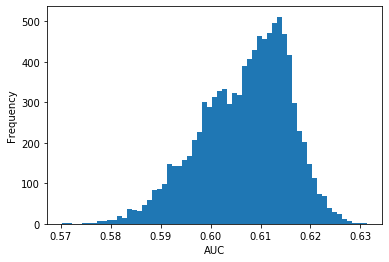

In [108]:
binwidth = 0.001
plt.hist(auc_total,bins=np.arange(np.min(auc_total), np.max(auc_total) + binwidth, binwidth))
plt.xlabel('AUC')
plt.ylabel('Frequency')

In [109]:
print(np.percentile(auc_total, 2.5))
print(np.percentile(auc_total, 97.5))

0.5878594249201278
0.6214721380855567
